In [1]:
from pathlib import Path
from indigo import Indigo
import numpy as np
import pandas as pd
import asyncio
import shutil

from substrucure_finder import BucketsInitializer
from substrucure_finder import SearchEngine, ThreadPoolSearchEngine

import fp_utils
from fp_utils.finders import Finder
from fp_utils.tests import FinderSpeedTester
from fp_utils.catch_time import CatchTime

In [2]:
fp_utils.settings.init_fp_utils()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
data_path = Path("../data/")

In [4]:
zero_columns_name = '../data/zero_columns'

# Build structure

In [5]:
raw_db_path = Path('/home/Vsevolod.Vaskin/qtr-fingerprint/data/raw_data_bases/2kk_mcc/')

In [6]:
db_path = Path('/home/Vsevolod.Vaskin/qtr-fingerprint/data/data_bases/2kk_50c_mcc/')

In [7]:
db_path.mkdir(exist_ok=True, parents=True)
(db_path / 'buckets').mkdir(exist_ok=True)
shutil.copy(raw_db_path / 'tree', db_path / 'tree')

PosixPath('/home/Vsevolod.Vaskin/qtr-fingerprint/data/data_bases/2kk_50c_mcc/tree')

In [8]:
initializer = BucketsInitializer(raw_db_path, db_path, columns_count=50)

In [9]:
%%time
initializer.init_buckets()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Start init 85
Finish init 85
Start init 86
Finish init 86
Start init 87
Finish init 87
Start init 88
Finish init 88
Start init 90
Finish init 90
Start init 91
Finish init 91
Start init 92
Finish init 92
Start init 105
Finish init 105
Start init 106
Finish init 106
Start init 109
Finish init 109
Start init 110
Finish init 110
Start init 134
Finish init 134
Start init 135
Finish init 135
Start init 139
Finish init 139
Start init 140
Finish init 140
Start init 141
Finish init 141
Start init 142
Finish init 142
Start init 145
Finish init 145
Start init 146
Finish init 146
Start init 151
Finish init 151
Start init 152
Finish init 152
Start init 161
Finish init 161
Start init 162
Finish init 162
Start init 163
Finish init 163
Start init 164
Finish init 164
Start init 165
Finish init 165
Start init 166
Finish init 166
Start init 167
Finish init 167
Star

Finish init 615
Start init 616
Finish init 616
Start init 621
Finish init 621
Start init 622
Finish init 622
Start init 629
Finish init 629
Start init 630
Finish init 630
Start init 631
Finish init 631
Start init 632
Finish init 632
Start init 633
Finish init 633
Start init 634
Finish init 634
Start init 635
Finish init 635
Start init 636
Finish init 636
Start init 637
Finish init 637
Start init 638
Finish init 638
Start init 639
Finish init 639
Start init 640
Finish init 640
Start init 641
Finish init 641
Start init 642
Finish init 642
Start init 643
Finish init 643
Start init 644
Finish init 644
Start init 645
Finish init 645
Start init 646
Finish init 646
Start init 657
Finish init 657
Start init 658
Finish init 658
Start init 661
Finish init 661
Start init 662
Finish init 662
Start init 666
Finish init 666
Start init 668
Finish init 668
Start init 669
Finish init 669
Start init 670
Finish init 670
Start init 681
Finish init 681
Start init 682
Finish init 682
Start init 683
Finish i

Finish init 1116
Start init 1121
Finish init 1121
Start init 1122
Finish init 1122
Start init 1123
Finish init 1123
Start init 1124
Finish init 1124
Start init 1129
Finish init 1129
Start init 1130
Finish init 1130
Start init 1133
Finish init 1133
Start init 1134
Finish init 1134
Start init 1145
Finish init 1145
Start init 1146
Finish init 1146
Start init 1149
Finish init 1149
Start init 1150
Finish init 1150
Start init 1151
Finish init 1151
Start init 1152
Finish init 1152
Start init 1155
Finish init 1155
Start init 1156
Finish init 1156
Start init 1157
Finish init 1157
Start init 1158
Finish init 1158
Start init 1167
Finish init 1167
Start init 1168
Finish init 1168
Start init 1171
Finish init 1171
Start init 1172
Finish init 1172
Start init 1173
Finish init 1173
Start init 1174
Finish init 1174
Start init 1175
Finish init 1175
Start init 1176
Finish init 1176
Start init 1177
Finish init 1177
Start init 1178
Finish init 1178
Start init 1185
Finish init 1185
Start init 1186
Finish ini

Finish init 1613
Start init 1614
Finish init 1614
Start init 1615
Finish init 1615
Start init 1616
Finish init 1616
Start init 1617
Finish init 1617
Start init 1618
Finish init 1618
Start init 1621
Finish init 1621
Start init 1622
Finish init 1622
Start init 1623
Finish init 1623
Start init 1624
Finish init 1624
Start init 1625
Finish init 1625
Start init 1626
Finish init 1626
Start init 1635
Finish init 1635
Start init 1636
Finish init 1636
Start init 1643
Finish init 1643
Start init 1644
Finish init 1644
Start init 1645
Finish init 1645
Start init 1646
Finish init 1646
Start init 1647
Finish init 1647
Start init 1649
Finish init 1649
Start init 1651
Finish init 1651
Start init 1652
Finish init 1652
Start init 1653
Finish init 1653
Start init 1654
Finish init 1654
Start init 1665
Finish init 1665
Start init 1666
Finish init 1666
Start init 1669
Finish init 1669
Start init 1670
Finish init 1670
Start init 1671
Finish init 1671
Start init 1672
Finish init 1672
Start init 1673
Finish ini

Finish init 2100
Start init 2101
Finish init 2101
Start init 2102
Finish init 2102
Start init 2105
Finish init 2105
Start init 2106
Finish init 2106
Start init 2107
Finish init 2107
Start init 2108
Finish init 2108
Start init 2115
Finish init 2115
Start init 2116
Finish init 2116
Start init 2119
Finish init 2119
Start init 2120
Finish init 2120
Start init 2127
Finish init 2127
Start init 2128
Finish init 2128
Start init 2129
Finish init 2129
Start init 2130
Finish init 2130
Start init 2139
Finish init 2139
Start init 2140
Finish init 2140
Start init 2141
Finish init 2141
Start init 2142
Finish init 2142
Start init 2151
Finish init 2151
Start init 2152
Finish init 2152
Start init 2155
Finish init 2155
Start init 2156
Finish init 2156
Start init 2161
Finish init 2161
Start init 2162
Finish init 2162
Start init 2165
Finish init 2165
Start init 2166
Finish init 2166
Start init 2171
Finish init 2171
Start init 2172
Finish init 2172
Start init 2173
Finish init 2173
Start init 2174
Finish ini

Finish init 2611
Start init 2612
Finish init 2612
Start init 2615
Finish init 2615
Start init 2616
Finish init 2616
Start init 2619
Finish init 2619
Start init 2620
Finish init 2620
Start init 2621
Finish init 2621
Start init 2622
Finish init 2622
Start init 2625
Finish init 2625
Start init 2626
Finish init 2626
Start init 2629
Finish init 2629
Start init 2630
Finish init 2630
Start init 2633
Finish init 2633
Start init 2634
Finish init 2634
Start init 2639
Finish init 2639
Start init 2640
Finish init 2640
Start init 2641
Finish init 2641
Start init 2642
Finish init 2642
Start init 2643
Finish init 2643
Start init 2644
Finish init 2644
Start init 2645
Finish init 2645
Start init 2646
Finish init 2646
Start init 2647
Finish init 2647
Start init 2648
Finish init 2648
Start init 2651
Finish init 2651
Start init 2652
Finish init 2652
Start init 2661
Finish init 2661
Start init 2662
Finish init 2662
Start init 2663
Finish init 2663
Start init 2664
Finish init 2664
Start init 2667
Finish ini

Finish init 3084
Start init 3093
Finish init 3093
Start init 3094
Finish init 3094
Start init 3097
Finish init 3097
Start init 3098
Finish init 3098
Start init 3103
Finish init 3103
Start init 3104
Finish init 3104
Start init 3105
Finish init 3105
Start init 3106
Finish init 3106
Start init 3107
Finish init 3107
Start init 3108
Finish init 3108
Start init 3109
Finish init 3109
Start init 3110
Finish init 3110
Start init 3113
Finish init 3113
Start init 3114
Finish init 3114
Start init 3121
Finish init 3121
Start init 3122
Finish init 3122
Start init 3123
Finish init 3123
Start init 3124
Finish init 3124
Start init 3131
Finish init 3131
Start init 3132
Finish init 3132
Start init 3133
Finish init 3133
Start init 3134
Finish init 3134
Start init 3135
Finish init 3135
Start init 3136
Finish init 3136
Start init 3145
Finish init 3145
Start init 3146
Finish init 3146
Start init 3149
Finish init 3149
Start init 3150
Finish init 3150
Start init 3151
Finish init 3151
Start init 3152
Finish ini

Finish init 3595
Start init 3596
Finish init 3596
Start init 3597
Finish init 3597
Start init 3598
Finish init 3598
Start init 3605
Finish init 3605
Start init 3606
Finish init 3606
Start init 3607
Finish init 3607
Start init 3608
Finish init 3608
Start init 3615
Finish init 3615
Start init 3616
Finish init 3616
Start init 3617
Finish init 3617
Start init 3618
Finish init 3618
Start init 3621
Finish init 3621
Start init 3622
Finish init 3622
Start init 3624
Finish init 3624
Start init 3626
Finish init 3626
Start init 3629
Finish init 3629
Start init 3631
Finish init 3631
Start init 3632
Finish init 3632
Start init 3633
Finish init 3633
Start init 3635
Finish init 3635
Start init 3636
Finish init 3636
Start init 3642
Finish init 3642
Start init 3644
Finish init 3644
Start init 3645
Finish init 3645
Start init 3646
Finish init 3646
Start init 3649
Finish init 3649
Start init 3650
Finish init 3650
Start init 3651
Finish init 3651
Start init 3652
Finish init 3652
Start init 3653
Finish ini

Finish init 4056
Start init 4057
Finish init 4057
Start init 4058
Finish init 4058
Start init 4065
Finish init 4065
Start init 4066
Finish init 4066
Start init 4067
Finish init 4067
Start init 4068
Finish init 4068
Start init 4071
Finish init 4071
Start init 4072
Finish init 4072
Start init 4073
Finish init 4073
Start init 4074
Finish init 4074
Start init 4085
Finish init 4085
Start init 4086
Finish init 4086
Start init 4087
Finish init 4087
Start init 4088
Finish init 4088
Start init 4091
Finish init 4091
Start init 4092
Finish init 4092
Start init 4093
Finish init 4093
Start init 4094
Finish init 4094
Start init 4099
Finish init 4099
Start init 4100
Finish init 4100
Start init 4101
Finish init 4101
Start init 4102
Finish init 4102
Start init 4109
Finish init 4109
Start init 4110
Finish init 4110
Start init 4111
Finish init 4111
Start init 4112
Finish init 4112
Start init 4131
Finish init 4131
Start init 4132
Finish init 4132
Start init 4133
Finish init 4133
Start init 4134
Finish ini

Finish init 4601
Start init 4602
Finish init 4602
Start init 4605
Finish init 4605
Start init 4606
Finish init 4606
Start init 4607
Finish init 4607
Start init 4608
Finish init 4608
Start init 4619
Finish init 4619
Start init 4620
Finish init 4620
Start init 4621
Finish init 4621
Start init 4622
Finish init 4622
Start init 4623
Finish init 4623
Start init 4624
Finish init 4624
Start init 4625
Finish init 4625
Start init 4626
Finish init 4626
Start init 4631
Finish init 4631
Start init 4632
Finish init 4632
Start init 4633
Finish init 4633
Start init 4634
Finish init 4634
Start init 4637
Finish init 4637
Start init 4638
Finish init 4638
Start init 4641
Finish init 4641
Start init 4642
Finish init 4642
Start init 4645
Finish init 4645
Start init 4646
Finish init 4646
Start init 4647
Finish init 4647
Start init 4648
Finish init 4648
Start init 4651
Finish init 4651
Start init 4652
Finish init 4652
Start init 4655
Finish init 4655
Start init 4656
Finish init 4656
Start init 4661
Finish ini

Finish init 5090
Start init 5091
Finish init 5091
Start init 5092
Finish init 5092
Start init 5095
Finish init 5095
Start init 5096
Finish init 5096
Start init 5097
Finish init 5097
Start init 5098
Finish init 5098
Start init 5101
Finish init 5101
Start init 5102
Finish init 5102
Start init 5103
Finish init 5103
Start init 5104
Finish init 5104
Start init 5105
Finish init 5105
Start init 5106
Finish init 5106
Start init 5111
Finish init 5111
Start init 5112
Finish init 5112
Start init 5113
Finish init 5113
Start init 5114
Finish init 5114
Start init 5115
Finish init 5115
Start init 5116
Finish init 5116
Start init 5121
Finish init 5121
Start init 5122
Finish init 5122
Start init 5129
Finish init 5129
Start init 5130
Finish init 5130
Start init 5131
Finish init 5131
Start init 5132
Finish init 5132
Start init 5133
Finish init 5133
Start init 5134
Finish init 5134
Start init 5135
Finish init 5135
Start init 5136
Finish init 5136
Start init 5143
Finish init 5143
Start init 5144
Finish ini

Finish init 5581
Start init 5582
Finish init 5582
Start init 5585
Finish init 5585
Start init 5586
Finish init 5586
Start init 5587
Finish init 5587
Start init 5588
Finish init 5588
Start init 5589
Finish init 5589
Start init 5590
Finish init 5590
Start init 5599
Finish init 5599
Start init 5600
Finish init 5600
Start init 5601
Finish init 5601
Start init 5602
Finish init 5602
Start init 5603
Finish init 5603
Start init 5604
Finish init 5604
Start init 5605
Finish init 5605
Start init 5606
Finish init 5606
Start init 5607
Finish init 5607
Start init 5608
Finish init 5608
Start init 5609
Finish init 5609
Start init 5610
Finish init 5610
Start init 5617
Finish init 5617
Start init 5618
Finish init 5618
Start init 5619
Finish init 5619
Start init 5620
Finish init 5620
Start init 5623
Finish init 5623
Start init 5624
Finish init 5624
Start init 5625
Finish init 5625
Start init 5626
Finish init 5626
Start init 5635
Finish init 5635
Start init 5636
Finish init 5636
Start init 5639
Finish ini

Finish init 6064
Start init 6065
Finish init 6065
Start init 6066
Finish init 6066
Start init 6069
Finish init 6069
Start init 6070
Finish init 6070
Start init 6071
Finish init 6071
Start init 6072
Finish init 6072
Start init 6073
Finish init 6073
Start init 6074
Finish init 6074
Start init 6075
Finish init 6075
Start init 6076
Finish init 6076
Start init 6085
Finish init 6085
Start init 6086
Finish init 6086
Start init 6089
Finish init 6089
Start init 6090
Finish init 6090
Start init 6105
Finish init 6105
Start init 6106
Finish init 6106
Start init 6109
Finish init 6109
Start init 6110
Finish init 6110
Start init 6111
Finish init 6111
Start init 6112
Finish init 6112
Start init 6115
Finish init 6115
Start init 6116
Finish init 6116
Start init 6119
Finish init 6119
Start init 6120
Finish init 6120
Start init 6121
Finish init 6121
Start init 6122
Finish init 6122
Start init 6127
Finish init 6127
Start init 6128
Finish init 6128
Start init 6129
Finish init 6129
Start init 6130
Finish ini

Finish init 6579
Start init 6580
Finish init 6580
Start init 6585
Finish init 6585
Start init 6586
Finish init 6586
Start init 6591
Finish init 6591
Start init 6592
Finish init 6592
Start init 6593
Finish init 6593
Start init 6594
Finish init 6594
Start init 6595
Finish init 6595
Start init 6596
Finish init 6596
Start init 6609
Finish init 6609
Start init 6610
Finish init 6610
Start init 6611
Finish init 6611
Start init 6612
Finish init 6612
Start init 6613
Finish init 6613
Start init 6614
Finish init 6614
Start init 6617
Finish init 6617
Start init 6618
Finish init 6618
Start init 6619
Finish init 6619
Start init 6620
Finish init 6620
Start init 6621
Finish init 6621
Start init 6622
Finish init 6622
Start init 6623
Finish init 6623
Start init 6624
Finish init 6624
Start init 6625
Finish init 6625
Start init 6626
Finish init 6626
Start init 6631
Finish init 6631
Start init 6632
Finish init 6632
Start init 6633
Finish init 6633
Start init 6636
Finish init 6636
Start init 6639
Finish ini

Finish init 7066
Start init 7067
Finish init 7067
Start init 7068
Finish init 7068
Start init 7073
Finish init 7073
Start init 7074
Finish init 7074
Start init 7077
Finish init 7077
Start init 7078
Finish init 7078
Start init 7081
Finish init 7081
Start init 7082
Finish init 7082
Start init 7083
Finish init 7083
Start init 7084
Finish init 7084
Start init 7085
Finish init 7085
Start init 7086
Finish init 7086
Start init 7087
Finish init 7087
Start init 7088
Finish init 7088
Start init 7089
Finish init 7089
Start init 7090
Finish init 7090
Start init 7093
Finish init 7093
Start init 7094
Finish init 7094
Start init 7095
Finish init 7095
Start init 7096
Finish init 7096
Start init 7103
Finish init 7103
Start init 7104
Finish init 7104
Start init 7109
Finish init 7109
Start init 7110
Finish init 7110
Start init 7113
Finish init 7113
Start init 7114
Finish init 7114
Start init 7119
Finish init 7119
Start init 7120
Finish init 7120
Start init 7123
Finish init 7123
Start init 7124
Finish ini

Finish init 7559
Start init 7560
Finish init 7560
Start init 7565
Finish init 7565
Start init 7566
Finish init 7566
Start init 7569
Finish init 7569
Start init 7570
Finish init 7570
Start init 7571
Finish init 7571
Start init 7572
Finish init 7572
Start init 7573
Finish init 7573
Start init 7574
Finish init 7574
Start init 7577
Finish init 7577
Start init 7578
Finish init 7578
Start init 7579
Finish init 7579
Start init 7580
Finish init 7580
Start init 7581
Finish init 7581
Start init 7582
Finish init 7582
Start init 7583
Finish init 7583
Start init 7584
Finish init 7584
Start init 7585
Finish init 7585
Start init 7586
Finish init 7586
Start init 7587
Finish init 7587
Start init 7588
Finish init 7588
Start init 7595
Finish init 7595
Start init 7596
Finish init 7596
Start init 7599
Finish init 7599
Start init 7600
Finish init 7600
Start init 7603
Finish init 7603
Start init 7604
Finish init 7604
Start init 7615
Finish init 7615
Start init 7616
Finish init 7616
Start init 7617
Finish ini

Finish init 8031
Start init 8032
Finish init 8032
Start init 8035
Finish init 8035
Start init 8036
Finish init 8036
Start init 8037
Finish init 8037
Start init 8038
Finish init 8038
Start init 8043
Finish init 8043
Start init 8044
Finish init 8044
Start init 8045
Finish init 8045
Start init 8046
Finish init 8046
Start init 8049
Finish init 8049
Start init 8050
Finish init 8050
Start init 8051
Finish init 8051
Start init 8052
Finish init 8052
Start init 8057
Finish init 8057
Start init 8058
Finish init 8058
Start init 8059
Finish init 8059
Start init 8060
Finish init 8060
Start init 8065
Finish init 8065
Start init 8066
Finish init 8066
Start init 8067
Finish init 8067
Start init 8068
Finish init 8068
Start init 8073
Finish init 8073
Start init 8074
Finish init 8074
Start init 8075
Finish init 8075
Start init 8076
Finish init 8076
Start init 8077
Finish init 8077
Start init 8078
Finish init 8078
Start init 8081
Finish init 8081
Start init 8083
Finish init 8083
Start init 8085
Finish ini

# Search Queries

In [5]:
with open(zero_columns_name, 'r') as f:
    zero_columns = list(map(int, f.read().split()))
assert list(sorted(zero_columns)) == zero_columns

In [6]:
full_columns = list(sorted(set(range(3736)) - set(zero_columns)))

In [7]:
def bin_format(number, num_of_bits=3736):
    fp = list(map(int, list(bin(int(number, 16))[2:].zfill(num_of_bits))))
    return np.fromiter(fp, dtype=int)

In [8]:
def smiles_to_fingerprint(smiles):
    indigo_mol_to_test = Indigo().loadMolecule(smiles)
    full_fp = bin_format(indigo_mol_to_test.fingerprint("sub").toString())
    return np.fromiter(pd.Series(full_fp)[full_columns].values, dtype=bool)

In [9]:
@CatchTime("search")
def search(smiles: str, finder: Finder, ans_count=None):
    fp = smiles_to_fingerprint(smiles)
    return list(finder.find(fp, ans_count))

In [10]:
class ComplexFinder(SearchEngine, Finder):   
    def find_all(self, fp):
        return self.search(fp)

In [11]:
class ThreadPoolFinder(ThreadPoolSearchEngine, Finder):   
    def find_all(self, fp):
        return self.search(fp)

In [12]:
with open('../data/pubchem_994_queries.txt', 'r') as f:
    queries = list(map(lambda x: x.split()[0], f.read().strip().split('\n')))

In [13]:
len(queries), queries[:10]

(157,
 ['Cc1c[n]c2[nH]ccc2c1Cl',
  'OC(=O)c1c[n]c2[nH]ccc2c1Cl',
  'Cc1c(Cl)c[n]c2[nH]ccc21',
  'Oc1c[n]c2[nH]ccc2c1Cl',
  'N[C@@H](C[S@](=O)CCO)C(O)=O',
  'OC(=O)c1ccc2[nH]ccc2[n]1',
  'N[C@@H](C[S@@](=O)CCO)C(O)=O',
  'COC(=O)[C@@H](O)CC([O-])=O',
  'OC(=O)c1[n]ccc2[nH]ccc21',
  'CC[NH2+]CC(C)C'])

In [14]:
queries_fp = [smiles_to_fingerprint(smiles) for smiles in queries]

In [15]:
mcc100_2kk = ComplexFinder(Path('/home/Vsevolod.Vaskin/qtr-fingerprint/data/data_bases/2kk_100c_mcc'))

0.018s -- ComplexFinder init time


In [16]:
from fp_utils.draw import MoleculeDrawer

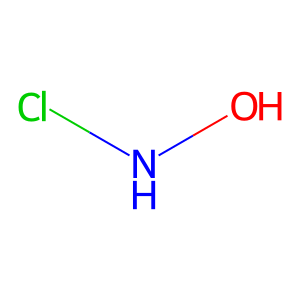

In [40]:
query = 'Cl-N-O'
MoleculeDrawer.draw_one(query)

In [41]:
answers = search(query, mcc100_2kk, ans_count=10)

18.978s -- search


In [42]:
len(answers)

10

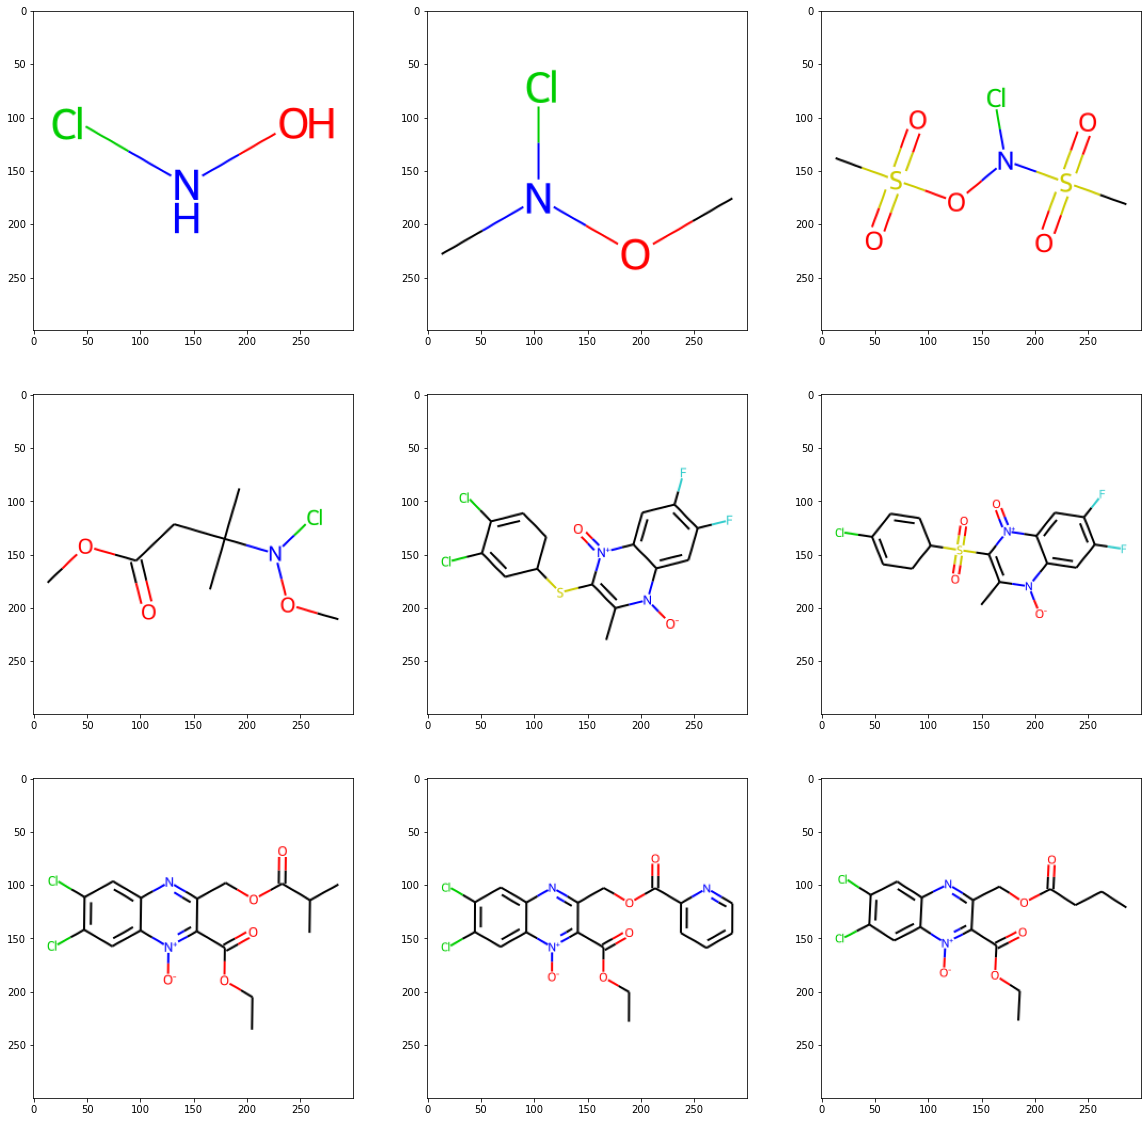

In [43]:
MoleculeDrawer.draw_many(answers, figsize=(20, 20), shape=(3, 3))